# Causal Model in Root Cause analysis
Note that DoWhy requires explicit causal graph definition. In order to buid the graph itself, you would need the domain knowledge (e.g. physical relationship or sequential order of operations) or partial correlation method in the section below. 

In [37]:
from dowhy import gcm
import networkx as nx
import pandas as pd
from random import uniform
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

## Example 1: Distribution change

In [268]:
# generate sample data
data_size = 100
gen_x = [uniform(-1,1) for _ in range(data_size)]       # uniform noise
gen_ya = [uniform(-1,1) for _ in range(data_size)]      # uniform noise
gen_yb = [gen_x[k]+uniform(-1,1) if k<80 else 3+uniform(-1,1) for k in range(data_size)]  # X + uniform noise 
# gen_yb = [uniform(-gen_yb[k]*0.1, gen_yb[k]*0.1) for k in range(data_size)]  # uniform noise dependent on X
gen_z = [gen_ya[k]*50 + gen_yb[k] for k in range(data_size)]   # directly dependent on Ya and Yb
data = pd.DataFrame({
    'X':gen_x,
    'Ya':gen_ya,
    'Yb':gen_yb,
    'Z':gen_z})

In [269]:
# inspect correlation
print('X->Ya:\t'  , round(spearmanr(gen_x, gen_ya).statistic,3))
print('X->Yb:\t'  , round(spearmanr(gen_x, gen_yb).statistic,3))
print('Ya->Yb:\t' , round(spearmanr(gen_ya, gen_yb).statistic,3))
print('----------------')
print('X->Z:\t'   , round(spearmanr(gen_x, gen_z).statistic,3))
print('Ya->Z:\t'  , round(spearmanr(gen_ya, gen_z).statistic,3))
print('Yb->Z:\t'  , round(spearmanr(gen_yb, gen_z).statistic,3))

X->Ya:	 -0.104
X->Yb:	 0.44
Ya->Yb:	 -0.089
----------------
X->Z:	 -0.089
Ya->Z:	 0.997
Yb->Z:	 -0.03


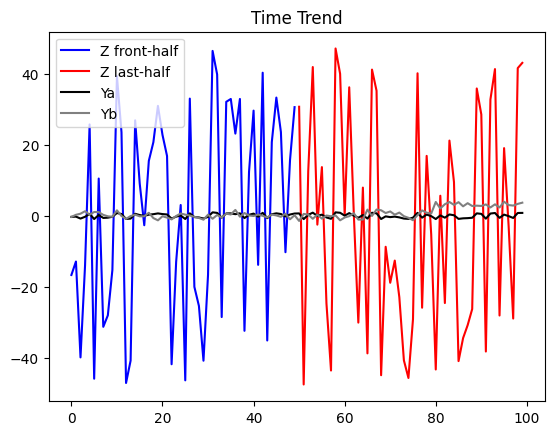

In [270]:
# plot trends
plt.plot(data.Z.iloc[:50], c='b', label='Z front-half')
plt.plot(data.Z.iloc[50:], c='r', label='Z last-half')
plt.plot(data.Ya, c='black', label='Ya')
plt.plot(data.Yb, c='gray', label='Yb')
plt.title("Time Trend")
plt.legend()

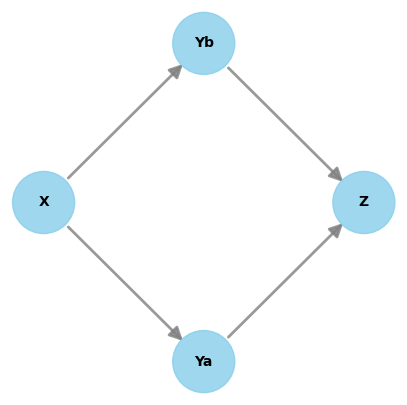

In [271]:
# STEP 1: Model cause-effect relationships as structural causal model X->(Ya,Yb)->Z
causal_graph = nx.DiGraph([('X','Ya'),('X','Yb'),('Ya','Z'),('Yb','Z')])
scm = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(scm, data)
gcm.util.plot(causal_graph)

In [272]:
# STEP 2: Fit causal mechanisms to data
gcm.fit(scm, data)

Fitting causal mechanism of node Z: 100%|██████████| 4/4 [00:00<00:00, 52.83it/s]


Evaluating set functions...: 100%|██████████| 4/4 [00:00<00:00, 3412.78it/s]


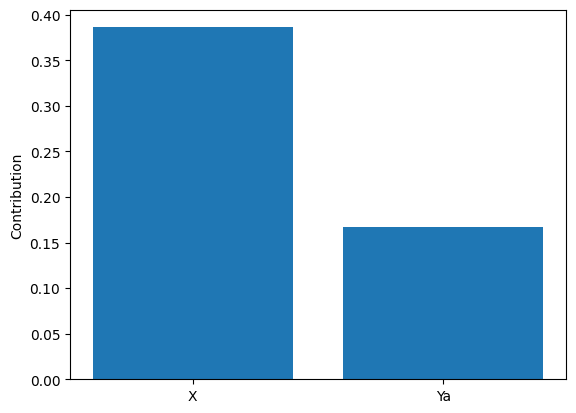

In [298]:
# STEP 3: Answer a query based on the SCM
contributions = gcm.distribution_change(scm, data.iloc[:50], data.iloc[50:], target_node='Ya')
plt.bar(contributions.keys(), contributions.values())
plt.ylabel('Contribution')
plt.show()

## Example 2: Anomaly

In [347]:
# generate sample data
data_size = 100
gen_x = [uniform(-1,1) for _ in range(data_size)]       # uniform noise
gen_ya = [uniform(-1,1) for _ in range(data_size)]      # uniform noise
gen_yb = [5+uniform(-1,1)
          if k in range(30,35) or k in range(55,60) or k in range(80,85)
          else gen_x[k]+uniform(-1,1) for k in range(data_size)]
gen_z = [gen_ya[k]*8 + gen_yb[k]**2 for k in range(data_size)]   # directly dependent on Ya and Yb
data = pd.DataFrame({
    'X':gen_x,
    'Ya':gen_ya,
    'Yb':gen_yb,
    'Z':gen_z})

In [348]:
# inspect correlation
print('X->Ya:\t'  , round(spearmanr(gen_x, gen_ya).statistic,3))
print('X->Yb:\t'  , round(spearmanr(gen_x, gen_yb).statistic,3))
print('Ya->Yb:\t' , round(spearmanr(gen_ya, gen_yb).statistic,3))
print('----------------')
print('X->Z:\t'   , round(spearmanr(gen_x, gen_z).statistic,3))
print('Ya->Z:\t'  , round(spearmanr(gen_ya, gen_z).statistic,3))
print('Yb->Z:\t'  , round(spearmanr(gen_yb, gen_z).statistic,3))

X->Ya:	 -0.138
X->Yb:	 0.565
Ya->Yb:	 0.033
----------------
X->Z:	 -0.062
Ya->Z:	 0.768
Yb->Z:	 0.377


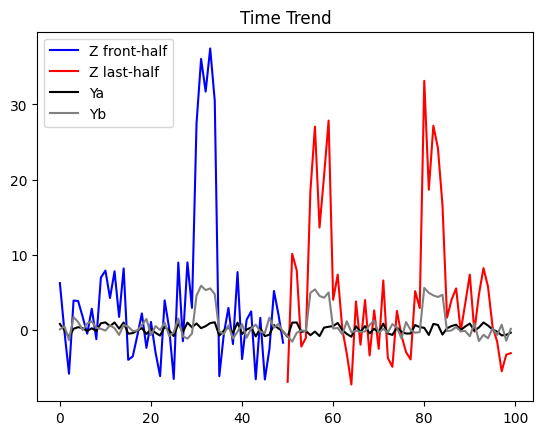

In [351]:
# plot trends
plt.plot(data.Z.iloc[:50], c='b', label='Z front-half')
plt.plot(data.Z.iloc[50:], c='r', label='Z last-half')
plt.plot(data.Ya, c='black', label='Ya')
plt.plot(data.Yb, c='gray', label='Yb')
plt.title("Time Trend")
plt.legend()

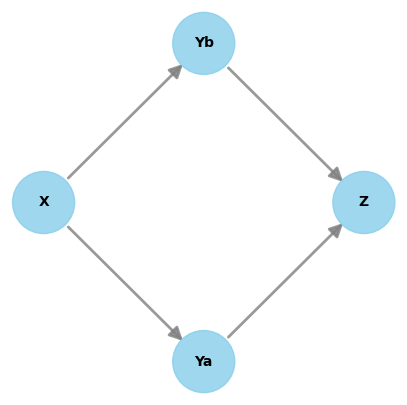

In [312]:
# STEP 1: Model cause-effect relationships as structural causal model X->(Ya,Yb)->Z
causal_graph = nx.DiGraph([('X','Ya'),('X','Yb'),('Ya','Z'),('Yb','Z')])
scm = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(scm, data)
gcm.util.plot(causal_graph)

In [313]:
# STEP 2: Fit causal mechanisms to data
gcm.fit(scm, data)

Fitting causal mechanism of node Z: 100%|██████████| 4/4 [00:00<00:00, 138.84it/s]


Evaluating set functions...: 100%|██████████| 16/16 [00:00<?, ?it/s]


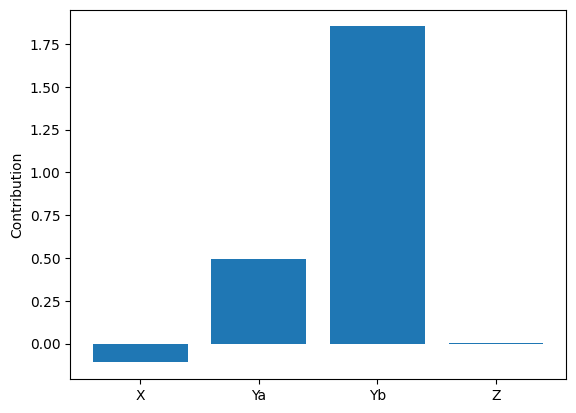

In [328]:
# STEP 3: Answer a query based on the SCM
contributions = gcm.attribute_anomalies(scm, 'Z', anomaly_samples=data.iloc[[30]])
plt.bar(contributions.keys(), [_l[0] for _l in contributions.values()])
plt.ylabel('Contribution')
plt.show()

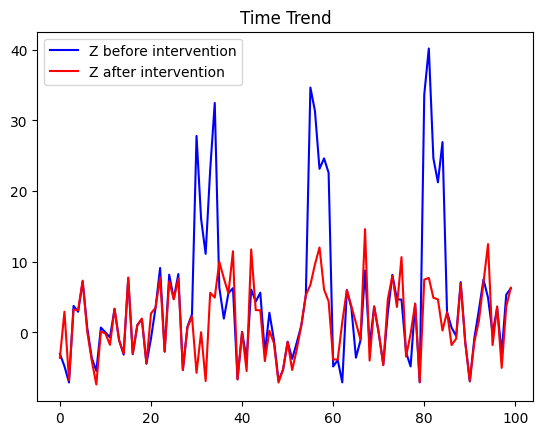

In [345]:
# simulate: perform intervention (reduce Yb variation by half)
intervention = gcm.interventional_samples(scm, {'Yb': lambda v: v*0.50}, observed_data=data)
# plot trends
plt.plot(data.Z, c='b', label='Z before intervention')
plt.plot(intervention.Z, c='r', label='Z after intervention')
plt.title("Time Trend")
plt.legend()

# Building causal graph with Partial Correlation
### Strategy:
1. Identify independent (Y) and dependents (Xs)
2. Only consider variables that show meaningful pairwise correlation (e.g. via p-value): $P(Y|X)$ 
3. Draw as much structure as we can; then investigate starting from the farthest parent node.
4. __TODO:__ Consider $p_{1,2}=P(x_1|x_2)$ and pairwise partial correlation within each child group: $pp_{1,2}=P(Y|x_1,x_2)$ and $pp_{2,1}=P(Y|x_2,x_1)$.
   * If $p_{1,2}$ is significant, then the two variables are highly correlated and should be grouped together. 
   * If $pp_{1,2}<<pp_{2,1}$, that means knowing $x_1$ captures most of the association. Thus, $x_2$ may not be a direct cause to $Y$ but could be causal to $x_1$: $X_2 \rightarrow X_1$
     * If p-value<0.05, for example, the partial correlation is significant and thus $t$ should represent a causal relationship with Y.
     * If p-value>0.05, then we may reject that $t$ represent a causal relationship with Y.
5. __TODO:__ Explore backdoor adjustment for confounder
6. Redraw the graph and groups

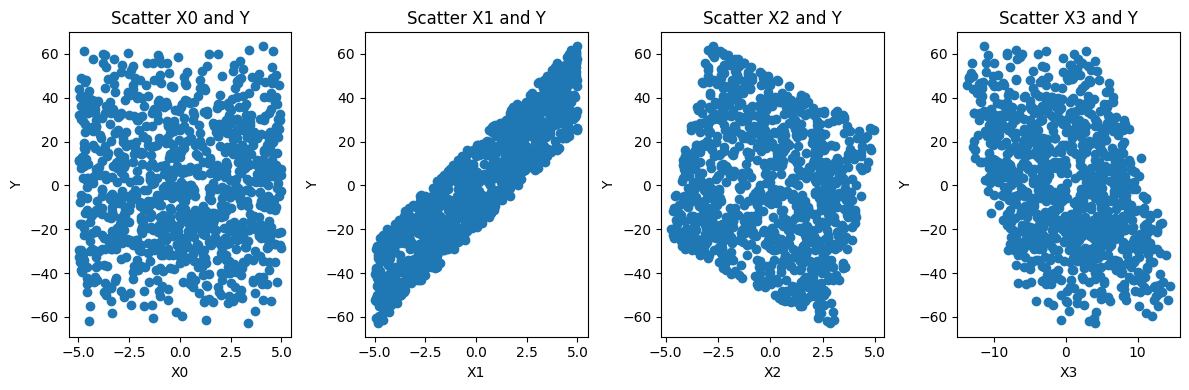

In [28]:
from pingouin import partial_corr
from scipy.stats import pearsonr
from random import uniform, shuffle
import pandas as pd
import matplotlib.pyplot as plt

""" On the importance of the i.i.d. assumption in statistical learning
https://stats.stackexchange.com/a/214315/177561
"""

# # Case 1: 3 truly independent variables (IID assumption)
# x0 = [uniform(-5, 5) for i in range(100)]
# x1 = [uniform(-5, 5) for i in range(100)]
# x2 = [uniform(-5, 5) for i in range(100)]
# x3 = [uniform(-1, 1) for i in range(100)]
# Case 2: X2 is dependent on x1
x0 = [uniform(-5, 5) for i in range(1000)]  # independent
x1 = [uniform(-5, 5) for i in x0]        # independent
x2 = [uniform(-4, 4)+i/5 for i in x1]    # dependent on x1
x3 = [uniform(-10, 10)-i for i in x1]    # dependent on x1
# # Independent shuffles breaks down dependencies between variables
# shuffle(x0)
# shuffle(x1)
# shuffle(x2)
# shuffle(x3)

dict = {
    'X0': x0,
    'X1': x1,
    # 'X1': [round(i,0)+round(uniform(-1,1),1) for i in x1],  # mimic sensor uncertainty and noise
    'X2': x2, 
    'X3': x3,
    # Linear: y=f(x0,x1,x2,e) where x0 is an unknown critical variable, and x3 is a counfounding factor
    'Y': [10*i - 5*j  for h,i,j,k in zip(x0,x1,x2,x3)], # no noise
    # 'Y': [5*h + 10*i - 5*j + uniform(-10,10) for h,i,j,k in zip(x0,x1,x2,x3)], # x0 is not the most significant variable
    # 'Y': [20*h + 10*i - 5*j + uniform(-1,1) for h,i,j,k in zip(x0,x1,x2,x3)], # x0 is the most significant variable
    
    # Linear: y=f(x0,x1,x2,x3,e)
    # 'Y': [ 10*i - 10*j +  10*k + uniform(-1,1) for h,i,j,k in zip(x0,x1,x2,x3)], 
    
    # Non-linear: y=f(x1,x2/x1)
    # 'Y': [ 10*i + 3*(j/i) for i,j,k in zip(x1,x2,x3)], 
} 
data = pd.DataFrame(dict)

# plot
fig,(ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(12,4))
ax0.scatter(data.X0, data.Y)
ax0.set_title("Scatter X0 and Y")
ax0.set_xlabel('X0')
ax0.set_ylabel('Y')
ax1.scatter(data.X1, data.Y)
ax1.set_title("Scatter X1 and Y")
ax1.set_xlabel('X1')
ax1.set_ylabel('Y')
ax2.scatter(data.X2, data.Y)
ax2.set_title("Scatter X2 and Y")
ax2.set_xlabel('X2')
ax2.set_ylabel('Y')
ax3.scatter(data.X3, data.Y)
ax3.set_title("Scatter X3 and Y")
ax3.set_xlabel('X3')
ax3.set_ylabel('Y')
plt.tight_layout()
plt.show()

In [29]:
# If critical variables are not accounted for, partial correlation will miss the effect. 
# Consider if we don't know X0 which is a factually important variable.
print('check partial correlation for X0')
print(f'corr(Y|X0) = {pearsonr(data.Y, data.X0).statistic**2:.2f}')
print(f'pcorr(Y|X0,X1) = {partial_corr(data=data, y='Y', x='X0', covar=['X1'], method='pearson').r.values[0]**2:.2f}')
print(f'pcorr(Y|X0,X2) = {partial_corr(data=data, y='Y', x='X0', covar=['X2'], method='pearson').r.values[0]**2:.2f}')
print(f'pcorr(Y|X0,X1,X2) = {partial_corr(data=data, y='Y', x='X0', covar=['X1', 'X2'], method='pearson').r.values[0]**2:.2f}')
print(f'//pcorr(Y|X0,X1,X2,X3) = {partial_corr(data=data, y='Y', x='X0', covar=['X1', 'X2', 'X3'], method='pearson').r.values[0]**2:.2f}')

print('\ncheck partial correlation for X1')
print(f'corr(Y|X1) = {pearsonr(data.Y, data.X1).statistic**2:.2f}')
print(f'pcorr(Y|X1,X2) = {partial_corr(data=data, y='Y', x='X1', covar=['X2'], method='pearson').r.values[0]**2:.2f}')
print(f'pcorr(Y|X1,X3) = {partial_corr(data=data, y='Y', x='X1', covar=['X3'], method='pearson').r.values[0]**2:.2f}')
print(f'pcorr(Y|X1,X2,X3) = {partial_corr(data=data, y='Y', x='X1', covar=['X2', 'X3'], method='pearson').r.values[0]**2:.2f}')
print(f'//pcorr(Y|X1,X0,X2,X3) = {partial_corr(data=data, y='Y', x='X1', covar=['X0', 'X2', 'X3'], method='pearson').r.values[0]**2:.2f}')

print('\ncheck partial correlation for X2')
print(f'corr(Y|X2) = {pearsonr(data.Y, data.X2).statistic**2:.2f}')
print(f'pcorr(Y|X2,X1) = {partial_corr(data=data, y='Y', x='X2', covar=['X1'], method='pearson').r.values[0]**2:.2f}')
print(f'pcorr(Y|X2,X3) = {partial_corr(data=data, y='Y', x='X2', covar=['X3'], method='pearson').r.values[0]**2:.2f}')
print(f'pcorr(Y|X2,X1,X3) = {partial_corr(data=data, y='Y', x='X2', covar=['X1', 'X3'], method='pearson').r.values[0]**2:.2f}')
print(f'//pcorr(Y|X2,X0,X1,X3) = {partial_corr(data=data, y='Y', x='X2', covar=['X0', 'X1', 'X3'], method='pearson').r.values[0]**2:.2f}')

print('\ncheck partial correlation for X3')
print(f'corr(Y|X3) = {pearsonr(data.Y, data.X3).statistic**2:.2f}')
print(f'pcorr(Y|X3,X1) = {partial_corr(data=data, y='Y', x='X3', covar=['X1'], method='pearson').r.values[0]**2:.2f}')
print(f'pcorr(Y|X3,X2) = {partial_corr(data=data, y='Y', x='X3', covar=['X2'], method='pearson').r.values[0]**2:.2f}')
print(f'pcorr(Y|X3,X1,X2) = {partial_corr(data=data, y='Y', x='X3', covar=['X2', 'X1'], method='pearson').r.values[0]**2:.2f}')
print(f'//pcorr(Y|X3,X0,X1,X2) = {partial_corr(data=data, y='Y', x='X3', covar=['X0', 'X1', 'X2'], method='pearson').r.values[0]**2:.2f}')

check partial correlation for X0
corr(Y|X0) = 0.00
pcorr(Y|X0,X1) = 0.00
pcorr(Y|X0,X2) = 0.00
pcorr(Y|X0,X1,X2) = 0.00
//pcorr(Y|X0,X1,X2,X3) = 0.00

check partial correlation for X1
corr(Y|X1) = 0.84
pcorr(Y|X1,X2) = 0.08
pcorr(Y|X1,X3) = 0.81
pcorr(Y|X1,X2,X3) = 0.03
//pcorr(Y|X1,X0,X2,X3) = 0.03

check partial correlation for X2
corr(Y|X2) = 0.03
pcorr(Y|X2,X1) = 0.09
pcorr(Y|X2,X3) = 0.07
pcorr(Y|X2,X1,X3) = 0.04
//pcorr(Y|X2,X0,X1,X3) = 0.04

check partial correlation for X3
corr(Y|X3) = 0.16
pcorr(Y|X3,X1) = 0.00
pcorr(Y|X3,X2) = 0.19
pcorr(Y|X3,X1,X2) = 0.11
//pcorr(Y|X3,X0,X1,X2) = 0.11
